# Daydacna: 
## Creating a daily geochemical cycle based Age estimate using wavelet transform

## Import needed packages

In [9]:
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import scipy as sc
from scipy import signal
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pycwt
import tkinter as tk
from tkinter import filedialog
import glob
import os
from tqdm import tqdm

## Necessary functions

In [10]:
# funktion to plot the wavelet scalogram  and Mg/Ca
def plot_wavelet(t, dt, scales, power, period, input_signal, signal_longterm):
    fig = plt.figure(figsize=(14, 7))
    
    ax1 = fig.add_axes((0.1, 0.1, 0.9, 0.6)) # positioning of the subplots
    ax2 = fig.add_axes((0.1, 0.7, 0.9, 0.3))
    
    ax2.sharex(ax1)# make them share the same x axis 

    im = ax1.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
                extend='both', cmap=plt.cm.jet)

    # Plot the cone of influence
    ax1.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                               t[:1] - dt, t[:1] - dt]),
            np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                               np.log2(period[-1:]), [1e-9]]),
            'r', alpha=0.4, hatch="xxx")

    # set y limit until which the wavelet scalgram is displayed
    ylim=2**7 
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(ylim)))
    ax1.set_yticks(np.log2(yticks))
    ax1.set_yticklabels(yticks)
    ax1.set_ylim(np.log2(ylim), 0)
    ax1.set_xlim(t.iloc[0], t.iloc[data_range-1])

    # name axis
    ax1.set_ylabel('Wavelength [μm]')
    ax1.set_xlabel('Distance [μm]')
    
    # adapt if wanted    
    ax2.set_ylabel(analyten)
    
    #ax1.axhline(np.log2(spotsize), c="white", ls=":")# uncomment if you want to display the spot size in the figure

    # Plot the smoothed analyte data
    ax2.plot(t, signal_longterm, c="k", alpha=0.3)
    ax2.plot(t, input_signal, c="k", alpha=0.3)
    
    ax2.spines['bottom'].set_color("none")
    ax2.tick_params(axis='x', colors="none")
    fig.tight_layout()
    return fig

#function to save the location of the points selected on the wavelet graph 
def getloc(ar, val):
    return np.argmin(np.abs(ar - val))

# function for gausian normal destribution needed for gaus
def gaussian(x, mu, sig):
    rv = sc.stats.norm(loc=mu, scale=sig)
    return rv.pdf(x)/np.sum(rv.pdf(x))

# function to interpolate through the NaNs, Convolve through the data
#interpolate the whiskers (first and last data points that fall within half of the smoothing window size).
def convolvewrap(x, y, w, kind="smoothed1"):
    nans = np.isnan(y)  # Tuple array of where the NaNs are.
    # Linearly interpolate through the NaNs
    interpolator = sc.interpolate.interp1d(
        x[~nans],
        y[~nans],
        kind="linear",
        fill_value="extrapolate",
        assume_sorted=True)
    # Use the object interpolator with the X values
    inters = interpolator(x)
    # fftconvolve is >3x faster than numpy.
    
    # Convolve a flat distribution through the data in "valid" mode.
    # This mode exclude the edges at half the window width.
    
    if kind == "smoothed1":
        wei = np.ones(int(w))/int(w)
        smoothed = sc.signal.fftconvolve(inters, wei, mode='same')  
    elif kind == "uniform":
        wei = np.ones(int(w))/int(w)
        smoothed = sc.signal.fftconvolve(inters, wei, mode='valid')  
    elif kind == "gaussian":
        xs = np.linspace(w - w, w + w,num=w)
        wei = gaussian(xs, w, w/2)
        smoothed = sc.signal.fftconvolve(inters, wei, mode='valid')  
    else:
        print(f"The {kind} distribution is not implemented")
        return None
    
    # Fill back the edges with linear interpolation or previeously determined LOEWESS curve
    hw = w//2
    # Sometime the lengths do not match, reajust.
    if len(x[(w - hw):(w + hw)]) != len(smoothed[:w]):
        diff = 2   # Greater difference between the convoluted arrays.
        sw = w - 1
    else:
        diff = 1
        sw = w 
    #calculate the edges
    if kind == "uniform" or kind == "gaussian":
        a, b = np.polyfit(x[(w - hw):(w + hw)], smoothed[:sw], 1) # Linear fit of the beginning
        bny = a*x[:w - hw] + b
    
        a, b = np.polyfit(x[-(w + hw):-(w - hw)], smoothed[-sw:], 1) # Linear fit of the end
        eny = a*x[-(w - hw):] + b
        # Combine all three arrays
        smooth_comp = np.concatenate((bny, smoothed[diff:], eny))
    else:
    #instead use LOWESS values for whiskers:
        bny = man_period_smooth_mc[mc, :sw]
        eny = man_period_smooth_mc[mc, -sw:]
        # Combine all three arrays.
        smooth_comp = np.concatenate((bny, smoothed[sw-diff:-sw-diff], eny))
        
    return smooth_comp

# Part 1: Reading in data and preprocessing

### Getting the data set and the variables for processing

In [11]:
%matplotlib inline 

file_path=filedialog.askopenfilename() # select file

# get name of data file and dirtectory
file_name = os.path.basename(file_path)
directory_name = os.path.dirname(file_path)
directory=directory_name+r"/"
sample_name=os.path.splitext(file_name)[0]

#spotsize = 3 #in um; uncomment if you want to display this in the figures

# make a forlder for the data
folder_name = f"{directory}_daydacna_{sample_name}"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# read in the file
if file_name[-4:] == ".csv":
    dfn = pd.read_csv(file_path)
elif file_name[-5:] == ".xlsx":
    dfn = pd.read_excel(file_path)
elif file_name[-5:] == ".txt":
    pd.read_csv(file_path, sep=" ")
else:
    print('File type not recognized. Please use a csv, txt or xlsx data file.')

data_range=len(dfn)
print(dfn.columns)

Index(['Absolute Time', 'Elapsed Time', 'B11_mmolmol', 'Na23_mmolmol',
       'Mg24_mmolmol', 'Al27_mmolmol', 'Sr88_mmolmol', 'Y89_mmolmol',
       'Ba138_mmolmol'],
      dtype='object')


### secelct the columns for time/distance and all element ratios that are to be used for analysis

In [12]:
#select the right time column

t_n = [dfn.columns[1]]

print('You chose "' + str(t_n) + '" as the time column.' )

#select the element ratios you want to replot over time using Daysacna

yxn = [dfn.columns[2], dfn.columns[3], dfn.columns[5], dfn.columns[6], dfn.columns[8]]

print('You to chose apply Daydacna on the following elements: ' +str(yxn))

#select the anaylite: the element ratio wavelet transfomtion is perfomed on
analyten = [dfn.columns[4]] 

print('You chose "' + str(analyten) + '" as the signal to perform wavelet transform on.')

combined_headers = t_n+yxn

t_raw = dfn[t_n[0]]
yxs = []
for i in range(len(yxn)):
    yxs.append(dfn[yxn[i]])

You chose "['Elapsed Time']" as the time column.
You to chose apply Daydacna on the following elements: ['B11_mmolmol', 'Na23_mmolmol', 'Al27_mmolmol', 'Sr88_mmolmol', 'Ba138_mmolmol']
You chose "['Mg24_mmolmol']" as the signal to perform wavelet transform on.


## Remove outliers from data (optional)

In [13]:
remove_ouliers=False #change to False if no outlier rejection should be performed

if remove_ouliers:
    x_SD = 2 # reject ouliers over x_SD, adapt value
    yxs_mask=[]

    for ys in yxs:
        detr = sm.nonparametric.lowess(ys, t_raw, 20/data_range)# change detrending range if wanted
        a = np.abs(ys[:]-detr[:,1])
        b = ys.mask(a>x_SD*np.std(a))
        yxs_mask.append(b)

    list_no_outliers = [t_raw]

    for i in range(len(yxs)):
            yxs_mask[i]=yxs_mask[i].interpolate()
            list_no_outliers.append(yxs_mask[i])

    dfn = pd.DataFrame(list_no_outliers)
    dfn = pd.DataFrame.transpose(dfn)
    dfn.dropna(inplace=True)#rows with nan values are droped
    #dfn.to_csv(folder_name+"\\"+sample_name+ "_no_outliers.csv", sep=',', index=None)
    print('outliers outside ' +str(x_SD)+' SD of the detrended signal are now removed and gaps are interpolated.')

else:
    dfn.dropna(inplace=True)#rows with nan values are droped
    print('proceding without outlier rejection.')


data_range=len(dfn) # if only part of data set schold be used the value can be adapted

proceding without outlier rejection.


# Part 2: Wavelet calculation and plotting

### Select the data used in wavelet tranfrom 

In [14]:
#resets the data from in case outliers were rejected and rows with nan values were droped

t_0 = dfn[t_n[0]] # here Elapsed Time (s) along the measured pathway
scan_speed = 1 # here in units um/s 
t=t_0*scan_speed # multiply time with scan speed to get distance along the sample

dt = t.iloc[1] - t.iloc[0]  # Time of step, for the wavelet transform

input_signal = dfn[analyten[0]]
sig = np.array(input_signal)# this signal is then smoothed and used for wavelet transform

signal_trend = sm.nonparametric.lowess(input_signal, t, 600/data_range)[:,1]
#smoothing that gives the rough trend for the longterm variablitiy of the analyte

## Set countinous wavelet tranform parameters and calculate

In [15]:
# used pycwt package
# Home page of package with tutorial / install guide: https://pycwt.readthedocs.io/en/latest/index.html#

mother = pycwt.Morlet(6)  # Change the number to change the wavelet, 6 is actually pretty good.

wave, scales, freqs, coi, fft, fftfreqs = pycwt.cwt(sig, dt, wavelet=mother)  # Run the wavelet transform
power = (np.abs(wave)) ** 2  # Convert into power
period = 1 / freqs

levels = [2**i for i in range(-12, 0)] #levels of color for correaltion depiction
#(if the image is too red choose lower values, if the image is too blue choose higher values)

## Set Plotting function and plot 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2376\2723817875.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


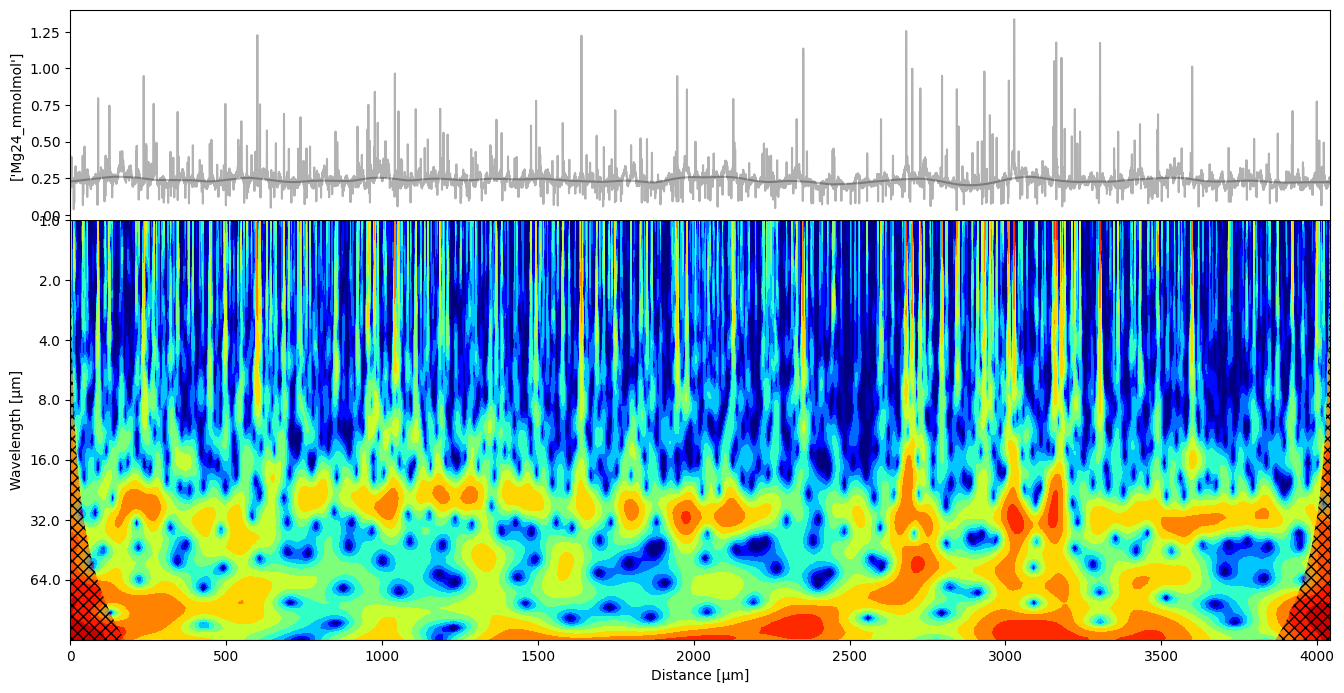

In [16]:
ax = plot_wavelet(t, dt, scales, power, period, input_signal, signal_trend) # wavelet plot exicution

# Part 3: Detection of daily wavelenghts 

## Automated maxima (dominant frequency) detection, interpolation and smoothing: automted daily growth rate 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2376\2723817875.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


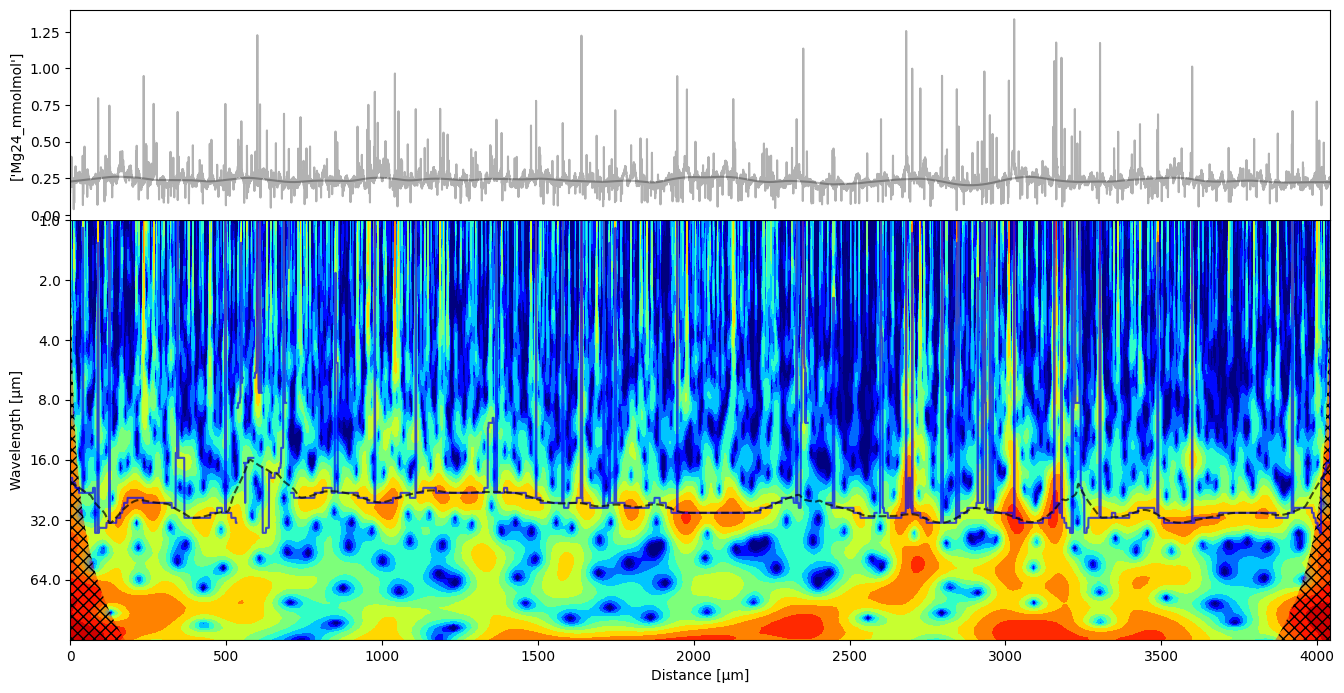

In [17]:
#Find Mixima

bands = np.log2(period)
#make empty numpy array to fill with locations of power maxima throughout the scalogram later 
mc_n = 1
period_res = np.zeros(power.shape[1])
power_thresh = [2**-7]

for mc in tqdm(range(mc_n)):
    # Only take data that has frequencies between 0.87um and ~40um 
    
    #-> MOVE adapt if needed 
    lb, ub = 4, 71
        
    xsig_ws = bands[lb:ub]
    # Loop through the record 
    for i in range(power.shape[1] - 1):
        sig_ws = power[lb:ub, i] # only use data that has frequencies between 0.87um and ~40um
        
        maxind = np.argmax(sig_ws)  # Find the index of the maxima in the power

        grad = np.gradient(sig_ws)  # Calculate the derivative of the power

        # Find index of where the sign of the gradient changes
        idx = np.argwhere(np.diff(np.sign(grad))).flatten() 

        # Find the gradients close to 0
        if idx.size == 0: # If there is no local maxima or minima
            period_res[i] = np.nan
            
            continue
        
        maxgrad = np.argmax(sig_ws[idx])  # Location of the maximum value based on gradients 0    
        if sig_ws[idx][maxgrad] < power_thresh[mc]:  # If the value of power is too low, kick it
            period_res[i] = np.nan
            
            continue
        
        # When all else fail, take the band width of the peak of power.
        else:
            period_res[i] = xsig_ws[idx][maxgrad]

smoothing_factor = 1.0/3e1    # Fraction of the data to consider for each point.
period_smooth = sm.nonparametric.lowess(period_res, t, smoothing_factor, xvals=t)#smooth and interpolate resulting curve of maxima
#use redo peroid smooth for first attemt not MC

fig = plot_wavelet(t, dt, scales, power, period, input_signal, signal_trend)
fig.axes[0].plot(t, period_res, c="b", alpha=0.7)
fig.axes[0].plot(t, period_smooth, c="k", alpha=0.7 ,ls='--')
plt.show()

## Manual adaption: Interactive plot to correct for wrongly selected maxima

### Reselect areas in which daily cyclicity is likely found, if and the program misselected other frequencies
Follow the daily signal you would like to reselect by right klicking along its path. If you resection for one area is done, press enter. Then proceed to reselect a pathwax in another area. If there are no more areas you would like to change, press enter once more (without right klicking on the figure).   

In [18]:
%matplotlib qt

mc_n = 1000

man_period_res = period_res.copy()
man_period_smooth = period_smooth.copy()
# Copy an array X number of times through X dimensions.
man_period_smooth_mc = np.tile(man_period_smooth.copy(), (mc_n, 1))


donesies = True

correction_number = 0

found_coords = {}
# Select the new points to force the algorythm into the correct path.
while donesies:
    # Plot the data
    fig = plot_wavelet(t, dt, scales, power, period, input_signal, signal_trend)
    fig.axes[1].set_title("Select points to force new trend. Press ENTER when done. Press ENTER again to finish.\n"
                         "Left click to select, right click to remove point.")
    fig.axes[0].plot(t, period_res, c="grey")
    fig.axes[0].plot(t, period_smooth, c="k", ls=":", alpha=0.9)
    
    coords = plt.ginput(-1, -1)  # Record the coordinates on the plot.
    
    if len(coords) == 0: # If no points were taken, assume it to be done.
        donesies = False
        plt.close()
        break

    plt.close()  # Close the figure.
    correction_number += 1  # Record the number of corrections. 
    found_coords[correction_number] = coords
    

for c in found_coords:
    # Remove the duplicates in coords by changing array into a dictionary
    fcoords = np.array(list(dict.fromkeys(found_coords[c])))
    # But sometimes, you have the same x value for different y values
    # so we need a second filter
    # Get the difference between each point and add a dummy number at the end
    # to be the same length as the original
    diffn = np.append(np.diff(fcoords[:, 0]), 1)
    # Create a mask of indices when the difference between to x values 
    # are above 0, also gets rid of clicking backwards
    maskers = np.where(diffn > 0)
    # Filter the manually selected points.
    found_coords[c] = fcoords[maskers, :][0]

    
coordsmc = {}
for c in found_coords: # Loop through each group of coordinates
    coords = found_coords[c]
    coordsmc[c] = {}
    # Loop through each coordinate to create a random array of x and y.
    for i, co in enumerate(coords):
        xmc = np.random.normal(co[0], co[0]*0.01, mc_n)  # 1% uncertainty
        ymc = np.random.normal(co[1], co[1]*0.01, mc_n)
        coordsmc[c][i] = [xmc, ymc]
        
    for i in range(len(coords)-1):   # Loop over each selected points
        coordx1mc = coordsmc[c][i][0]
        coordx2mc = coordsmc[c][i+1][0]
        y1mc = coordsmc[c][i][1]
        y2mc = coordsmc[c][i+1][1]
        # Loop through the randomised x and y values
        for mc in range(mc_n):
            x1 = getloc(t, coordx1mc[mc])   # Get the index of the selected values
            x2 = getloc(t, coordx2mc[mc])
            ys = [y1mc[mc],y2mc[mc]]

            # Fit a straight line between the two selected points
            m, inte = np.polyfit([x1, x2], ys, 1)
            xs = np.arange(x1, x2)
            ys = m * xs + inte
            man_period_smooth_mc[mc, x1:x2] = ys


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2376\2723817875.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


## Reselected intervals are included and used for daily cycle wavelenght (=daily growthrate) selection and the signal is smoothed

In [19]:
%matplotlib inline 
redo_period_res = period_res.copy()
redo_period_res_mc = np.tile(period_res.copy(), (mc_n, 1))

# Set boundaries and threshold_power
bd_min, bd_max = 1.0, 9.0
threshold_power = 2**-7

res_area = 0.5 # area arround the smoothed curve it should consider to both sides for resampling for maxima 
res_area_mc = np.random.normal(0.5, 0.05, mc_n)

for c in found_coords:
    for mc in tqdm(range(mc_n)): # Loop through each Monte Carlo simulation
        start = getloc(t, coordsmc[c][0][0][0])  # Get the first x value of the first selected point
        m = max(coordsmc[c].keys()) # Get the last point of a selected point group.
        end = getloc(t, coordsmc[c][m][0][-1])  # Get the last x value of the last point.
        
        for i in range(start, end - 1):
            # Extract signal around the selected data point  
            x1 = man_period_smooth_mc[mc, i] - res_area_mc[mc]
            ind1 = getloc(bands, x1)
            x2 = man_period_smooth_mc[mc, i] + res_area_mc[mc]
            ind2 = getloc(bands, x2)
         
            xsig = bands[ind1:ind2]
            sig = power[ind1:ind2, i]
            maxind = np.argmax(sig)

            grad = np.gradient(sig)

            # Find index of where the sign of the gradient changes
            idx = np.argwhere(np.diff(np.sign(grad))).flatten() 
            
            # Find the gradients close to 0
            if idx.size == 0: # If there is no local maxima or minima
                # Check if it is a dark band based on daily band width

                if bd_min < 2**man_period_smooth_mc[mc, i] < bd_max: # if selected point is between 1 and 5 um
                    # Check that there are some values above threshold
                    if sum(sig > threshold_power):
                        # Convert to list to get index of the first value that crosses
                        # the threshold value
                        index_min = list(sig > threshold_power).index(True)  
                        redo_period_res_mc[mc, i] = xsig[index_min] # Save the band width of that index
                        continue
                # If none of the above worked, then just fill with NaN
                redo_period_res_mc[mc, i] = np.nan
                continue


            maxgrad = np.argmax(sig[idx])  # Location of the maximum value based on gradients 0
            if sig[idx][maxgrad] < threshold_power:  # If the value of power is too low, kick it
                redo_period_res_mc[mc, i] = np.nan
                continue
            # When all else fail, take the band width of the peak of power.
            redo_period_res_mc[mc, i] = xsig[idx][maxgrad]  

for mc in tqdm(range(mc_n)):
    for x in range(len(redo_period_res_mc[0, :])):
        if redo_period_res_mc[mc, x] > man_period_smooth_mc[mc, x]+res_area_mc[mc]:#+res_area:
           redo_period_res_mc[mc, x] = np.nan
           
        elif redo_period_res_mc[mc,x] < man_period_smooth_mc[mc, x]-res_area_mc[mc]:#-res_area:
            redo_period_res_mc[mc, x] = np.nan

per_envelope=np.percentile(res_area_mc, (2.5, 50, 97.5), axis=0)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 77.04it/s]


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2376\2723817875.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


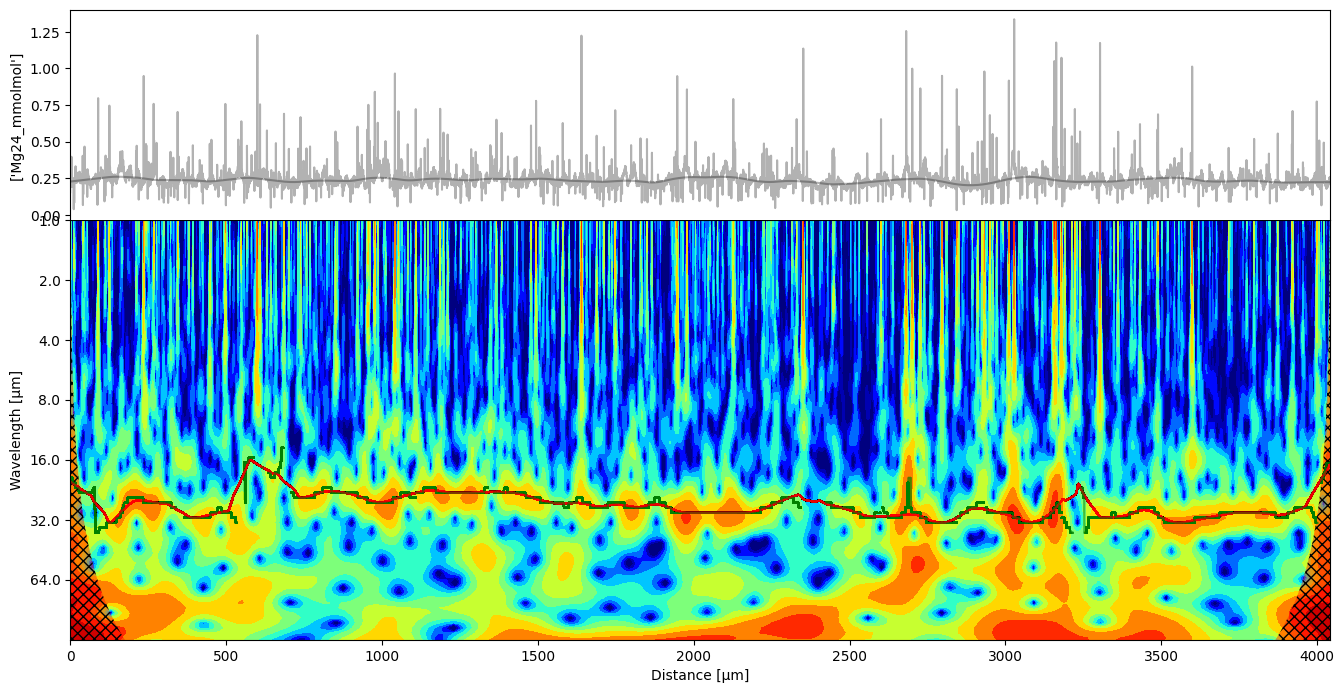

In [20]:
# signal and wavelet plot with manual coreections (if needed) 
fig = plot_wavelet(t, dt, scales, power, period, input_signal, signal_trend)
for mc in range(mc_n):
    fig.axes[0].plot(t, redo_period_res_mc[mc, :], c="g", ls="-", alpha=0.05) # new maxima
    fig.axes[0].plot(t, man_period_smooth_mc[mc, :], c="r", ls="-", alpha=0.05) # new areas incl. error of manualy selceted points


In [21]:
%matplotlib inline

period_smooth_mc = redo_period_res_mc.copy()

# Get the incremental steps of the dataset
incr_steps = list(np.diff(t))  
incr_steps.insert(0, 0.0)
incr_steps = np.array(incr_steps)


smoothing_factors = np.arange(100, 500, 20) #smoothing factors for Monte Carlo simulation 

smooth_r = np.zeros(mc_n)
      
smoothing_factor_lowess = 300/len(t)  # Fraction of the data to consider for each point.
period_smooth_lowess = sm.nonparametric.lowess(redo_period_res_mc[0,:], t, smoothing_factor_lowess, xvals=t)#smooth and interpolate resulting curve of maxima

var_smooth = False
if var_smooth:  # If you want to vary the smoothing factor mean
    days_mc = np.zeros((len(smoothing_factors), mc_n, mc_n))
else:
    days_mc = np.zeros(mc_n)

    
smooth_rate = np.random.normal(400, 75, mc_n)
days_cumul = np.zeros((mc_n, redo_period_res_mc.shape[1]))

for i in tqdm(range(mc_n)):
    period_smooth = convolvewrap(t, redo_period_res_mc[i, :], int(abs(smooth_rate[i])), kind="gaussian")
    period_smooth_mc[i, :] = period_smooth
    days_estimate = np.cumsum((1/(2**period_smooth))*incr_steps)
    days_cumul[i] = days_estimate
    days_mc[i] = days_estimate[-1]




100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 200.44it/s]


### Plot of all the smoothed pathways

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2376\2723817875.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


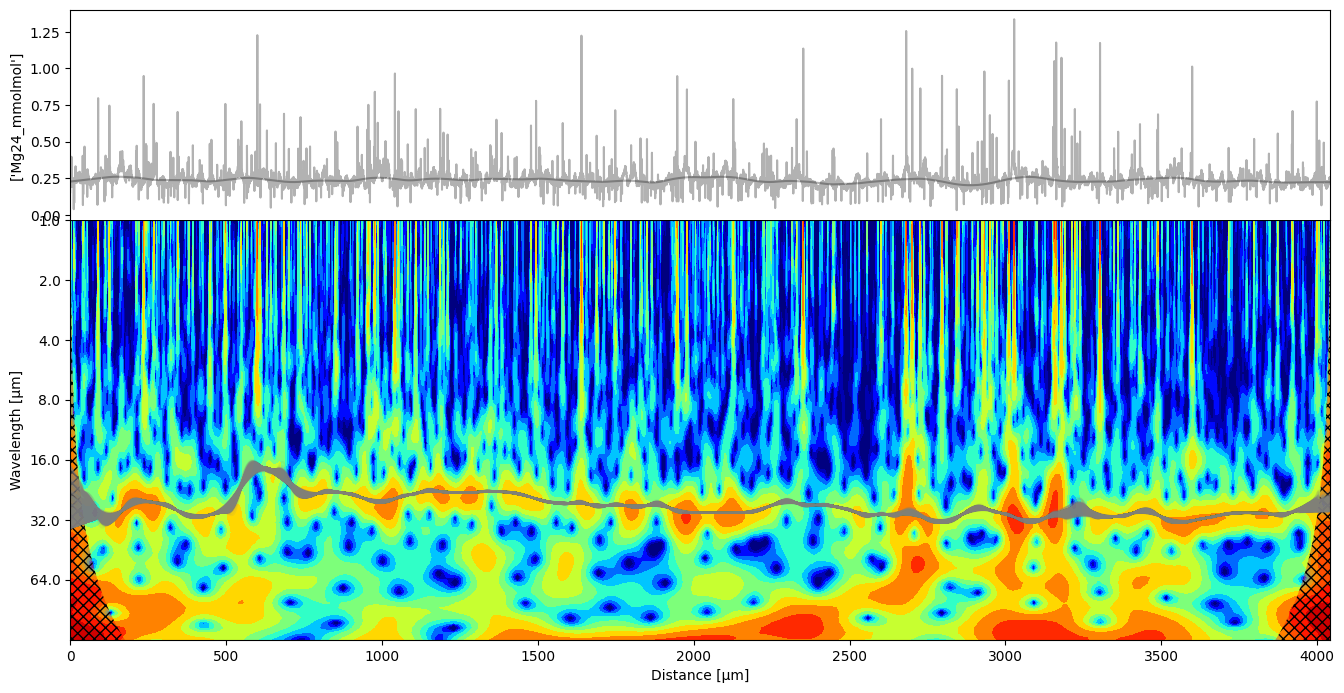

In [22]:
fig = plot_wavelet(t, dt, scales, power, period, input_signal, signal_trend)
for mc in range(mc_n):
    fig.axes[0].plot(t, period_smooth_mc[mc, :], c="gray", ls="-", alpha=0.1)

## Calculation of days in the dataset and plot of growthrate (days over distance)

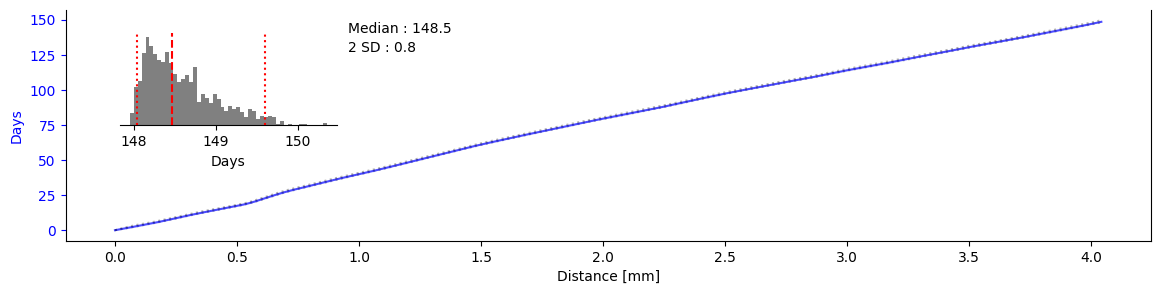

In [23]:

fig, ax1 = plt.subplots(figsize=(14, 3)) 

tmm=t/1000

ax1.spines['top'].set_visible(False)
#for i in range(mc_n):
#    ax1.plot(tmm, days_cumul[i], color = "blue", alpha=0.01)
 
per = np.percentile(days_cumul, (2.5, 16, 50, 84, 97.5), axis=0)    

plt.plot(tmm, per[0, :], alpha=0.3, c="k", ls=":")
plt.plot(tmm, per[2, :], alpha=0.7, c="b", ls="-")
plt.plot(tmm, per[4, :], alpha=0.3, c="k", ls=":")

ax1.tick_params(axis="y", colors='blue')
ax1.set_xlabel("Distance [mm]")
ax1.set_ylabel("Days", color = "blue")

days_mean = round(np.median(days_mc), 1)
days_sd = round(np.std(days_mc), 1)

axins = ax1.inset_axes([0.05, 0.5,  0.2, 0.4])

axins.hist(days_mc, bins=50, color="gray")

axins.axvline(np.percentile(days_mc, 50), color="r", ls="--")
axins.axvline(np.percentile(days_mc, 2.5), color="r", ls=":")
axins.axvline(np.percentile(days_mc, 97.5), color="r", ls=":")
axins2 = axins.twinx()

axins2.spines["top"].set_visible(False)
axins2.spines["left"].set_visible(False)
axins2.spines["right"].set_visible(False)
axins2.get_yaxis().set_visible(False)
axins.set_xlabel("Days")
axins.spines["top"].set_visible(False)
axins.spines["left"].set_visible(False)
axins.spines["right"].set_visible(False)
axins.spines["bottom"].set_visible(False)
axins.get_yaxis().set_visible(False)

axins.text(1.05, 1.0, f"Median : {days_mean}", transform=axins.transAxes)
axins.text(1.05, 0.8, f"2 SD : {days_sd * 2}", transform=axins.transAxes)


plt.show()

figpng=folder_name+"\\"+sample_name+ '_growth_rate_over_distance.png'
#fig.savefig(figpng, bbox_inches='tight', transparent=False,  dpi=300)# uncooment if you want to save this figure

### save the data table with the determined days at certain distances and the original data

In [24]:
daily_growth = pd.DataFrame(list(zip(t_raw, per[2, :])), columns=["Distance [μm]", "Days"])

dot=pd.concat([daily_growth.iloc[:,1], dfn], axis=1)
dot.dropna(inplace=True) # to drop 0st row

#only in windows-> make relative ./
dot.to_csv(folder_name+"\\"+sample_name+ '_data_over_time.csv')

### save error estimate with 2.5th, 50th and 97.5th percentiles for the growth rate and estimate of days

In [25]:
per_GR = np.percentile(period_smooth_mc, (2.5, 50, 97.5), axis=0)    

growthrate_and_days = pd.DataFrame(list(zip(t, per_GR[0, :], per_GR[1, :], 
                                            per_GR[2, :],per[0, :], 
                                            per[2, :], per[4, :])), 
                                   columns=['time [s]','Growthrate percentile 2.5', 'Growthrate percentile 50',
                                            'Growthrate percentile 97.5','Cumulative days percentile 2.5',
                                            'Cumulative days percentile 50', 'Cumulative days percentile 97.5'])


growthrate_and_days.to_csv(folder_name+"\\"+sample_name+ "_GR_parameters.csv", sep=',', index=None)

## Part 4: displaying data over time


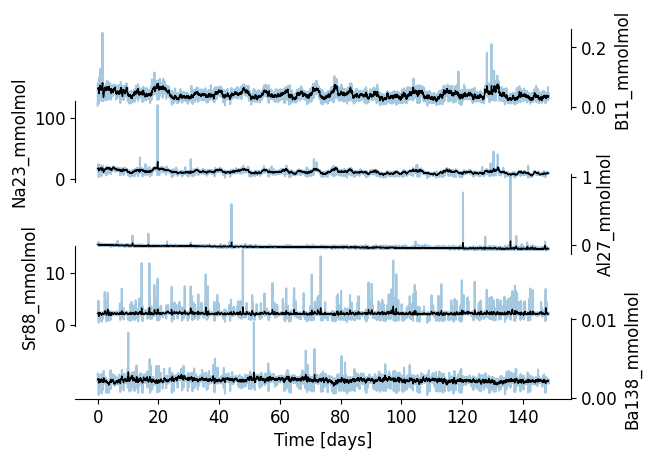

In [29]:
%matplotlib inline 
plt.rcParams['font.size']=12

dot=pd.read_csv(folder_name+"\\"+sample_name+"_data_over_time.csv")

x=dot['Days'].values


fig = plt.figure()
gs = fig.add_gridspec(len(yxn), hspace=-0.1)
axs = gs.subplots(sharex=True)

for i in range(len(yxn)):
    if i == len(yxn)-1 and (i % 2 == 0):
        axs[i].set_facecolor('none')
        axs[i].set_ylim(auto=True)
        axs[i].spines['left'].set_color("none")
        axs[i].spines['top'].set_color("none")
        axs[i].set_xlabel(r'Time [days]')
        axs[i].yaxis.tick_right()
        axs[i].yaxis.set_label_position("right")
        axs[i].set_ylabel(yxn[i])
        axs[i].plot(x,dot[yxn[i]], alpha=0.4)
        axs[i].plot(x[10:-10],np.convolve(dot[yxn[i]], np.ones(10)/10, mode='same')[10:-10], c='k', lw=1)
    elif i == len(yxn)-1 and (i % 2 != 0):
        axs[i].set_facecolor('none')
        axs[i].set_ylim(auto=True)
        axs[i].spines['right'].set_color("none")
        axs[i].spines['top'].set_color("none")
        axs[i].set_xlabel(r'Time [days]')
        axs[i].yaxis.set_label_position("left")
        axs[i].set_ylabel(yxn[i])
        axs[i].plot(x,dot[yxn[i]], alpha=0.4)
        axs[i].plot(x[10:-10],np.convolve(dot[yxn[i]], np.ones(10)/10, mode='same')[10:-10], c='k', lw=1)
    elif (i % 2 == 0):
        axs[i].set_facecolor('none')
        axs[i].set_ylim(auto=True)
        axs[i].spines['top'].set_color("none")
        axs[i].spines['left'].set_color("none")
        axs[i].spines['bottom'].set_color("none")
        axs[i].tick_params(axis='x', colors="none")
        axs[i].yaxis.set_label_position("right")
        axs[i].yaxis.tick_right()
        axs[i].set_ylabel(yxn[i])
        axs[i].plot(x,dot[yxn[i]], alpha=0.4)
        axs[i].plot(x[10:-10],np.convolve(dot[yxn[i]], np.ones(10)/10, mode='same')[10:-10], c='k', lw=1)
    else:
        axs[i].set_facecolor('none')
        axs[i].set_ylim(auto=True)
        axs[i].spines['right'].set_color("none")
        axs[i].spines['top'].set_color("none")
        axs[i].spines['bottom'].set_color("none")
        axs[i].tick_params(axis='x', colors="none")
        axs[i].yaxis.set_label_position("left")
        axs[i].set_ylabel(yxn[i])
        axs[i].plot(x,dot[yxn[i]], alpha=0.4)
        axs[i].plot(x[10:-10],np.convolve(dot[yxn[i]], np.ones(10)/10, mode='same')[10:-10], c='k', lw=1)


plt.show()

figpng=folder_name+"\\"+sample_name+ '_El_over_time.png'
fig.savefig(figpng, bbox_inches='tight', transparent=False,  dpi=300)

# daydacna sumary figure function

In [27]:
def plot_daydacna(time, scales, power, period, mgca, growth):
    fig = plt.figure(figsize=(10.5, 7.25))
    plt.rcParams['font.size']=12
    

    ax1 = fig.add_axes((0.1, 0.59, 0.9, 0.15)) # positioning of the subplots
    ax2 = fig.add_axes((0.1, 0.2, 0.9, 0.3))
    ax3 = fig.add_axes((0.1, 0.0, 0.9, 0.2))    
    
    # make them share the same x axis 
    ax2.sharex(ax1)
    ax3.sharex(ax2)

# Plot the Mg/Ca data (incl. long term trend)
    ax1.plot(time, signal_trend, c="k", alpha=0.7)
    ax1.plot(t, input_signal, alpha=0.5, lw=0.5)
    
    ax1.set_ylabel(analyten)
    ax1.set_xlabel('Distance [μm]')
    
    ax1.yaxis.tick_right()
    ax1.yaxis.set_label_position("right")
    ax1.spines['right'].set_color('black')
    ax1.yaxis.label.set_color('black')
    ax1.tick_params(axis='y', color='black')
    
# plot the scalogram   
    im = ax2.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
                extend='both', cmap=plt.cm.jet)

    # Plot the cone of influence
    ax2.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                               t[:1] - dt, t[:1] - dt]),
            np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                               np.log2(period[-1:]), [1e-9]]),
            'r', alpha=0.4, hatch="xxx")


    ylim=2**7 # set y limit until which the wavelet scalgram is displayed
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(ylim)))
    ax2.set_yticks(np.log2(yticks))
    ax2.set_yticklabels(yticks)
    ax2.set_ylim(np.log2(ylim), 0)
    ax2.set_xlim(np.min(t), np.max(t))
    ax2.set_ylabel('Wavelength [μm]')
    
    #ax2.axhline(np.log2(spotsize), color="white", ls=':') # uncomment if you want to display the spotsize
 
    ax2.fill_between(t, per_GR[0, :],  per_GR[2, :], color='gray')
    ax2.fill_between(t, per_GR[0, :],  per_GR[2, :], color='gray')
    ax2.plot(t, per_GR[1, :], c="k", alpha=1, ls="--")
        
    ax2.spines['right'].set_color("none")
    ax2.spines['top'].set_color("none")
    ax2.spines['bottom'].set_color("none")
    ax2.tick_params(axis='x', colors="none")
    ax2.yaxis.set_label_position("left")
    ax2.spines['left'].set_color('black')
    ax2.yaxis.label.set_color('black')

    
# Plot the growth model
    ax3.fill_between(t, per[0, :],  per[4, :], color='blue')
    ax3.set_ylabel("Days", color = "blue")
    ax3.set_xlabel('Distance [μm]')
    ax3.set_ylim(min(per[0, :]),max(per[4, :]))
    
    ax3.spines['top'].set_color("none")
    ax3.yaxis.tick_right()
    ax3.tick_params(axis='y', colors='blue')
    ax3.yaxis.set_label_position("right")
    ax3.spines['right'].set_color('blue')
    ax3.yaxis.label.set_color('blue')
    ax3.tick_params(axis='y', color='blue')

    
# subplot
    
    axins = ax3.inset_axes([0.03, 0.5, 0.2, 0.4])
    axins.hist(days_mc, bins=50, color="gray")

    axins.axvline(np.percentile(days_mc, 50), color="r", ls="--")
    axins.axvline(np.percentile(days_mc, 2.5), color="r", ls=":")
    axins.axvline(np.percentile(days_mc, 97.5), color="r", ls=":")
    axins2 = axins.twinx()

    axins2.spines["top"].set_visible(False)
    axins2.spines["left"].set_visible(False)
    axins2.spines["right"].set_visible(False)
    axins2.get_yaxis().set_visible(False)
    axins.set_xlabel("Days")
    axins.spines["top"].set_visible(False)
    axins.spines["left"].set_visible(False)
    axins.spines["right"].set_visible(False)
    axins.spines["bottom"].set_visible(False)
    axins.get_yaxis().set_visible(False)

    axins.text(1.0, 0.9, f"Median : {days_mean}", transform=axins.transAxes)
    axins.text(1.0, 0.6, f"2 SD : {days_sd * 2}", transform=axins.transAxes)
    
    return fig



### apply funktion to polt summary figure

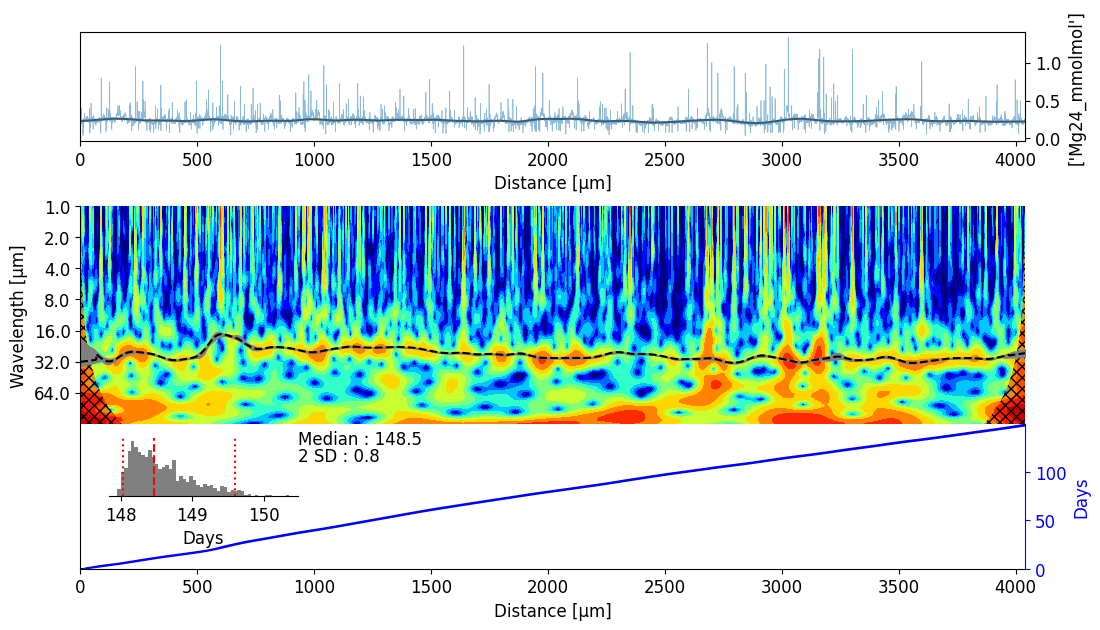

In [28]:
fig = plot_daydacna(t, scales, power, period, input_signal,  per[2, :])

figpng = folder_name+"\\"+sample_name+ '_wavelet_gr_RV.png'

fig.savefig(figpng, bbox_inches='tight', transparent=False,  dpi=300)